# Import Needed Packages

In [2]:
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
from sagemaker import get_execution_role
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

# Connect to S3 Bucket

In [3]:
# Get execution permissions
iam_role = get_execution_role()

In [4]:
# Specify Bucket Name
raw_data_bucket_name = "ads-508-spring2023-team3"

# Set up session parameters
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
personal_bucket = sagemaker_session.default_bucket()

# Establish an S3 connection
s3 = boto3.Session().client(service_name="s3", region_name=region)

In [5]:
# Set path to buckets (raw data and new personal bucket)
raw_data_path = 's3://{}'.format(raw_data_bucket_name)
personal_s3 = "s3://{}/london_data".format(personal_bucket)

In [6]:
# Check if connection to new personal s3 bucket was successfully established
try:
    bucket_contents = s3.list_objects(Bucket = personal_bucket)["Contents"]
    print("Connected to bucket successfully!\n")
    #print("Files in S3 bucket:")
    #for i in bucket_contents:
        #print(i["Key"])
except:
    # If connection failed, print error message
    print("##### ERROR #####")
    print("Could NOT connect to bucket: {} ({})".format(raw_data_bucket_name, personal_bucket))

Connected to bucket successfully!



In [7]:
# Create Unique Paths for Each CSV File
hourly_market_data_path = personal_s3 + "/market_data/Hourly_European_Market_Data.csv"
london_energy_path = personal_s3 + "/energy_data/London_Energy.csv"
london_weather_path = personal_s3 + "/weather_data/London_Weather_1979_2021.csv"

Athena will later create an external table based on the files of a bucket. Because all three files will act as a table for querying, all the files will need a unique path/folder.

# Copy Raw CSV Files to Personal S3 Bucket

In [8]:
!aws s3 cp --recursive $raw_data_path/ $hourly_market_data_path/ --exclude "*" --include "Hourly_European_Market_Data.csv"
!aws s3 cp --recursive $raw_data_path/ $london_energy_path/ --exclude "*" --include "London_Energy.csv"
!aws s3 cp --recursive $raw_data_path/ $london_weather_path/ --exclude "*" --include "London_Weather_1979_2021.csv"

copy: s3://ads-508-spring2023-team3/Hourly_European_Market_Data.csv to s3://sagemaker-us-east-1-510267762309/london_data/market_data/Hourly_European_Market_Data.csv/Hourly_European_Market_Data.csv
copy: s3://ads-508-spring2023-team3/London_Energy.csv to s3://sagemaker-us-east-1-510267762309/london_data/energy_data/London_Energy.csv/London_Energy.csv
copy: s3://ads-508-spring2023-team3/London_Weather_1979_2021.csv to s3://sagemaker-us-east-1-510267762309/london_data/weather_data/London_Weather_1979_2021.csv/London_Weather_1979_2021.csv


In [9]:
# Confirm that CSV files were copied to personal S3 bucket
!aws s3 ls $hourly_market_data_path/
!aws s3 ls $london_energy_path/
!aws s3 ls $london_weather_path/

2023-03-16 23:51:37  105185070 Hourly_European_Market_Data.csv
2023-03-16 23:51:39   95649585 London_Energy.csv
2023-03-16 23:51:40     814426 London_Weather_1979_2021.csv


# Create Athena Database

In [10]:
database_name = "london_data"

In [11]:
# Create a staging S3 directory - a temporary directory for querying
stage_dir = "s3://{}/athena/staging".format(personal_bucket)

In [12]:
# Connect to Staging Directory
try:
    pyathena_conn = connect(
        region_name = region, 
        s3_staging_dir = stage_dir)
    print("Connected to S3 staging directory!")
except:
    print("##### ERROR #####")
    print("##### Could NOT connect to S3 staging directory #####")

Connected to S3 staging directory!


In [13]:
# Create new Database - Print an error if there is a failure
try:
    sql_statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
    pd.read_sql(sql_statement, pyathena_conn)
    print("Database {} succesfully created!".format(database_name))
    sql_statement = "SHOW DATABASES"
    df_show = pd.read_sql(sql_statement, pyathena_conn)
    print(df_show.head(5))
except:
    print("##### ERROR #####")
    print("##### Could NOT create database #####")


Database london_data succesfully created!
  database_name
0       default
1        dsoaws
2   london_data


## Create Tables from CSV files

In [29]:
# SQL Create Table from Hourly Market Data CSV
table_name = "hourly_european_market_data_csv"
path_to_data = personal_s3 + "/market_data"

csv_table_statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Id int,
        Fecha date,
        Hora int,
        Sistema	string,
        Bandera	string,
        Precio float,
        Tipo_moneda	string,
        Origen_dato	string,
        Fecha_actualizacion	timestamp
    )
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}'
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, path_to_data)

# Execute Create Table Statement
pd.read_sql(csv_table_statement, pyathena_conn)
print("Succesfully made market_data table")

Succesfully made market_data table


In [35]:
# SQL Create Table from Energy CSV
table_name = "london_energy_csv"
path_to_data = personal_s3 + "/energy_data"

csv_table_statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        LCLid string,
        Date date,
        Kwh float
    )
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}'
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, path_to_data)

# Execute Create Table Statement
pd.read_sql(csv_table_statement, pyathena_conn)
print("Successfully created energy_data table")

Successfully created energy_data table


In [51]:
# SQL Create Table from Weather CSV
table_name = "london_weather_csv"
path_to_data = personal_s3 + "/weather_data"

csv_table_statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Date string,
        Cloud_cover float,
        Sunshine float,
        Global_radiation float,
        Max_temp float,
        Mean_temp float,
        Min_temp float,
        Precipitation float,
        Pressure float,
        Snow_depth float
    )
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}'
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, path_to_data)

# Execute Create Table Statement
pd.read_sql(csv_table_statement, pyathena_conn)
print("Successfully created weather_data table")

Successfully created weather_data table


_Note:_ The date in London_energy is formated as YYYYMMDD. It will have to be converted to the format (YYYY-MM-DD) for later joins.

In [56]:
# Show Created Tables
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, pyathena_conn)
df_show.head(5)

,tab_name
0,hourly_european_market_data_csv
1,london_energy_csv
2,london_weather_csv


In [65]:
# Show the first two rwos to ensure that the data looks correct
query = """
    SELECT *
    FROM {}.{}
    LIMIT 5
    """.format(database_name, "hourly_european_market_data_csv")

pd.read_sql(query, pyathena_conn)

,id,fecha,hora,sistema,bandera,precio,tipo_moneda,origen_dato,fecha_actualizacion
0,1504451,2020-09-19,17,DE,1,34.99,1,2,2021-10-01 12:39:53
1,1504452,2020-09-19,17,DK1,1,34.99,1,2,2021-10-01 12:39:53
2,1504453,2020-09-19,17,DK2,1,34.99,1,2,2021-10-01 12:39:53
3,1504454,2020-09-19,17,EE,1,49.89,1,2,2021-10-01 12:39:53
4,1504455,2020-09-19,17,ES,1,34.40,1,1,2021-10-01 12:39:53


In [66]:
query = """
    SELECT *
    FROM {}.{}
    LIMIT 5
    """.format(database_name, "london_energy_csv")

pd.read_sql(query, pyathena_conn)

,lclid,date,kwh
0,MAC003839,2013-06-14,7.034
1,MAC003839,2013-06-15,6.203
2,MAC003839,2013-06-16,2.780
3,MAC003839,2013-06-17,6.583
4,MAC003839,2013-06-18,6.038


In [67]:
query = """
    SELECT *
    FROM {}.{}
    LIMIT 5
    """.format(database_name, "london_weather_csv")

pd.read_sql(query, pyathena_conn)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


# Data Exploration in SQL via PyAthena

## Monthly Average Electricity Price

In [68]:
# Monthly average electricity price
query = """
    SELECT YEAR(fecha) AS Year,
        MONTH(fecha) AS Month,
        AVG(precio) AS Avg_Price
    FROM {}.hourly_european_market_data_csv
    GROUP BY YEAR(fecha), MONTH(fecha)
    ORDER BY YEAR(fecha), MONTH(fecha) asc;
    """.format(database_name)

monthly_avg_price = pd.read_sql(query, pyathena_conn)
monthly_avg_price.head(10)

,Year,Month,Avg_Price
0,2010,7,42.636627
1,2010,8,76.112564
2,2010,9,46.093450
3,2010,10,50.410633
4,2010,11,47.319530
5,2010,12,49.341072
6,2011,1,50.033813
7,2011,2,51.160927
8,2011,3,53.950410
9,2011,4,52.013780


In [69]:
# Modify output
avg_price = monthly_avg_price
# Merge Year and month to create a date column
avg_price["Date"] = avg_price["Year"].map(str) + '-' + avg_price["Month"].map(str)

# Create a Month_name column
avg_price["Month_name"] = avg_price["Month"].apply(lambda x: calendar.month_abbr[x])

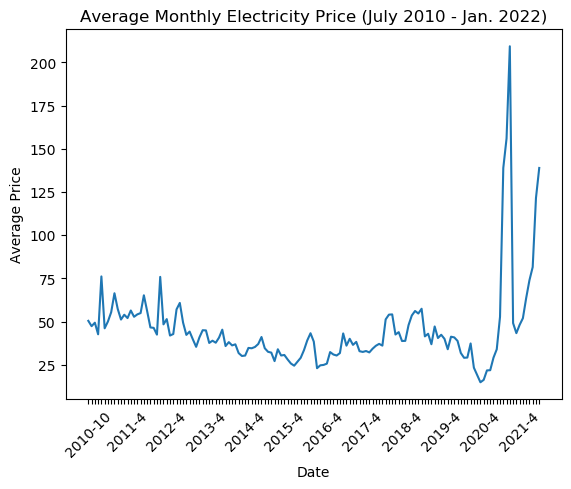

In [70]:
# Plot of monthly average electricity price
ax = plt.gca()
sns.lineplot(
    data = avg_price, 
    x = "Date", y = "Avg_Price")
for index, label in enumerate(ax.get_xticklabels()):
   if index % 12 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)
plt.xticks(rotation=45)
plt.ylabel("Average Price")
plt.title("Average Monthly Electricity Price (July 2010 - Jan. 2022)")
plt.show()

There was a large spike in the monthly average electricity price in late 2020, most likely due to increased usage by customers.

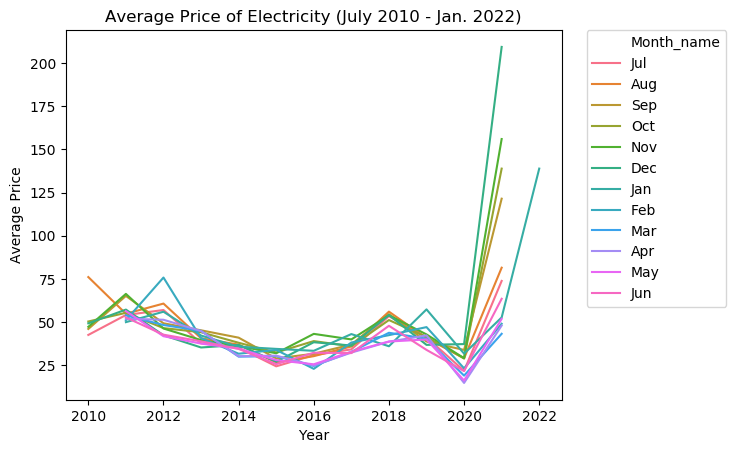

In [71]:
# Plot Monthly Average Price of Electricity Across Years
sns.lineplot(
    data = avg_price,
    x = "Year", y = "Avg_Price",
    hue = "Month_name")
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", borderaxespad = 0)
plt.ylabel("Average Price")
plt.title("Average Price of Electricity (July 2010 - Jan. 2022)")
plt.show()

By plotting each average monthly price as its own line, the sudden increase in price began in 2021 and persisted to the start of 2022.

## Average Hourly Electricity Price

In [72]:
query = """
    SELECT YEAR(fecha) AS Year,
        MONTH(fecha) AS Month,
        hora AS Hour,
        AVG(precio) AS Avg_Price
    FROM {}.hourly_european_market_data_csv
    GROUP BY 1, 2, 3
    ORDER BY 1, 2, 3 asc;
    """.format(database_name)

avg_hourly_price_df = pd.read_sql(query, pyathena_conn)
avg_hourly_price_df.head(10)

,Year,Month,Hour,Avg_Price
0,2010,7,1,34.444000
1,2010,7,2,30.008001
2,2010,7,3,28.882545
3,2010,7,4,25.865637
4,2010,7,5,26.308000
5,2010,7,6,30.040090
6,2010,7,7,36.611908
7,2010,7,8,44.018180
8,2010,7,9,43.738728
9,2010,7,10,46.889730


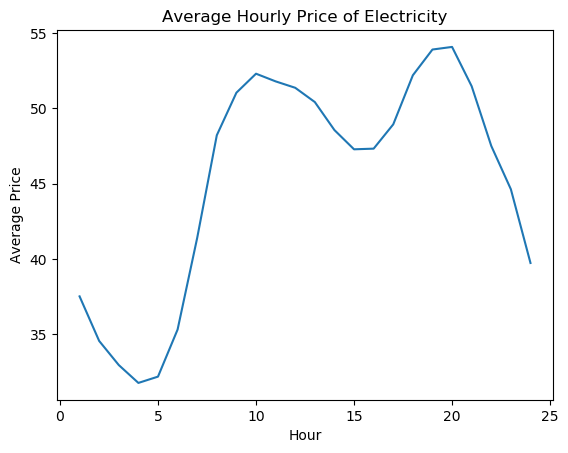

In [78]:
# Plot the averaged hourly prices of electricity
avg_hourly_price = avg_hourly_price_df.groupby(["Hour"]).mean("Avg_Price")

sns.lineplot(
    data = avg_hourly_price,
    x = avg_hourly_price.index, y = "Avg_Price")
plt.ylabel("Average Price")
plt.title("Average Hourly Price of Electricity")
plt.show()

The above plot shows that the most expensive times of the day are around 10:00 and 20:00 (or 10 a.m. and 8 p.m. respectively).

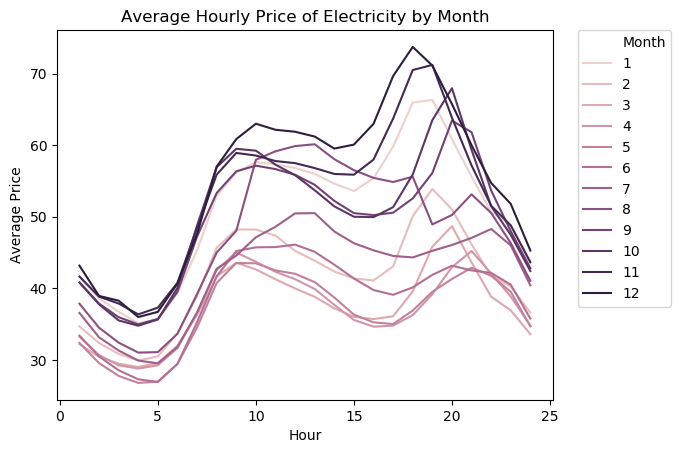

In [98]:
# Group first by month then by hour
avg_monthly_hourly_price = avg_hourly_price_df.groupby(["Month", "Hour"]).mean(["Avg_Price"]).reset_index()

# Plot Hourly Data with a line per month
sns.lineplot(
    data = avg_monthly_hourly_price,
    x = "Hour", y = "Avg_Price",
    hue = "Month", legend = "full")

plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", borderaxespad = 0)
plt.ylabel("Average Price")
plt.title("Average Hourly Price of Electricity by Month")
plt.show()

The above plot indicates that the cost of electricity increases both with the later months of the year. More specifically, electricity costs rise in the night (between 15:00/3 P.M. and 20:00/8 P.M.).

- Ingest raw data to Athena and trim the data to all be within the same time frame
- Export the data back out to S3

# Release Resources

In [26]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [27]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>